<a href="https://colab.research.google.com/github/priyaduseja/AB-Testing/blob/main/AB_Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Problem Statement**: Urban wear is a clothing brand that's launching an ecommerce store. Currently, the pre-launch stage is collecting emails from site visitors. The plan is to collect as many emails for the website launch.

As a product data scientist at Urban wear, your goal is to design, run and analyse an AB experiment that tests two versions of the email sign-up on the pre-launch page.

The control is the blue submit button, which is the current version. The treatment is the green submit button.

Help the product team at Urban wear decide which version to use based on the AB test result.

In [2]:
# Importing libraries

#Built-in libraries
from datetime import datetime
import random
import math

#Third Party libraries
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MultipleLocator
from statsmodels.stats.power import TTestIndPower, tt_ind_solve_power
from statsmodels.stats.weightstats import ttest_ind
from statsmodels.stats.proportion import proportions_chisquare, confint_proportions_2indep

#Disable warning
from warnings import filterwarnings
filterwarnings('ignore')

#Seed for np random
SEED = 123
np.random.seed(SEED)


In [5]:
# Loading the data
pretest = pd.read_csv("pretest.csv")
test = pd.read_csv("test.csv")

**Understanding the Business Problem**

As a part of umbrealla of understanding the business problem, there are 5 sections that we need to know.
1. Goals: What are the business and product goals of the experiment
2. Key Members: Who are the stakeholders that will sponsor a new product idea and the team that will execute the ide.
3. KPI: What are the key performance indicator that needs to be moved in the experiment?
4. Launch criteria: How do you quantitatively determine whether the experiment was a success?
5. Data: What's the data required to run the experiment?

**Experiment Goals in three levels**

1. Business: A business captures its primary goals to users in the form of a "mission statement". For example: Apple's mission statement is to "*bring the best experience to its customer using through the innvoative hardware, software and services.*"
2. Product: Based on business goal, the product goal is to provide tangible value to the users. Lets say Apple has three main products:


*   iPhone: A smartphone for contacts, work, notes, and entertainment
*   iPad: An easy to use smart tablet for work, notes, entertainment
*   Apple Music: A streaming service that provides a selection of million songs



3. Experimentation: Based on the product goal, an experimentation goal is to improve a particular feature of the product.


*   Iphone: Test a new facial recognition that allow users to unloack the phone without manually entering the passcode - *improve engagement*
*   Ipad: Test a new hand gesture that reduces deletion - or undo- rate of a task on Notes - *improves engagement*
*   Apple Music: Launch personalised marketing campaign to acquire new users - *improve user growth*





**Product Breakdown**

To know what to test in a product start by understanding the core product aspects:
*   **Problem**: What is the problem that product solves
*   **Users**: Who are the users using the product
*   **Onboarding**: What is the onboarding process of the product
*   **Journey**: What is the user experience from the beginning to the end of task
*   **Reward**: How does the product reward users
*   **Retention**: How does the product retain current users
*   **Growth**: How does the product grow users


**Product KPI**
*Metric Recipe*

1. Action: What is the main action you are measuring. Eg: Click, View, Post
2. Unit of Analysis: At what level do you want to measure action. Eg: User, Session, Month
3. Statistical Function: How do you want to quantify the action. Eg: Total, Average, Count.

There are various frameworks that you can use to come up with meaningful KPI - one of them is AAARRG framework!
1. Aquisition: How do customers find you?
2. Activation: How quickly do customers sign-up?
3. Retention: How long do customers stay active?
4. Referal: How do customers let others know about your product?
5. Revenue: How do you increase revenue?

Another framework is the heart framework:
1. Happiness: How satisfied and happy are your customers.
2. Engagement: How are customers engaged on your product?
3. Acquisition: How many new visitors are you getting per month?
4. Retention: What are the daily and monthly active users?
5. Task success: How long does it take for a user to complete a task?

**Metric Hierarchy**
Metric is a form of Hierarchy
1. The North Star Metric: The best measure for company's progress towards its mission statement.
2. Driver Metric: The Primary KPI measured at the product level; often used in AB testing.
3. Guardrail Metrics: A set of business and validity metrics that guardrails against a faulty experiment
4. Secondary Metrics: A set of metrics that track the micro-interactions of a user, helps further explain the driver metric
5. Segmentation: A set of metrics that further explains the variability among segments.

**The North Star Metric**
The main metric that we are trying to optimise. The North Star Metric (NSM, aka OSM) is the primary KPI that best measures the company's progress towards its mission. All areas of the business - marketing, product and engineering - are aligned toward moving these needles positively. There are three main properties of NSM:
1. Provies value to users
2. Contributes to Profit
3. Gauges Long Term Growth

For example, for Google - its mission statement : "To organise the world's information and make it universally accessible and useful. Its NSM is then -  Search queries per year.
For Meta, is "To give the power to build community and bring the world closer together". The NSM that would directly measure Meta - Total minutes consumed across Meta's ecosystem per year.
For Netflix, the mission statement is "To entertain the world". The NSM they care about is the number of subscribers per year.

**Driver Metric**
It is embedded below th North Star Metric. The driver metric is a product - or-feature level measure that proxies the NSM in short term. This metric is often selected in AB tests.
For Example, Google's NSM is Number of search Queries per Year, its driver metric that they care about is average daily search queries per user.
For Meta, its NSM is Total minutes consumed across meta's ecosystem. THe driver metriuc would be Average daily minutes consumed per user.
For Netflix, NSM is number of subscribers per year, its driver metric is the average daily minutes consumed per user.

**Guardrail Metric**
A set of metrics that measures the trade-offs in business decision and ensures that a test result is not skewed with bias. AB Test is an aspect of business you are imroving with an experiment. But there is a broader business implication you don't see if the outcome of your experiment is only based on primary KPI of the experiment. There are two types of guardrail metrics that you want to track:
1. Business Metric: Business KPIs related to the goal metric of an experiment.
2. Validity Metrics: Matrics that track potential biases in the experiment.
Every decision that we make in an AB test, to an extent have a tradeoff associated with it. Just because we see statistically significant results, doesn't mean that we should launch the product.

For exmple, Netflixs' NSM is the number of subscribers per year. We are trying to run an AB test to test a new recommendation system to increase engagement. The driver metric is average daily minutes consumed per user. The guardrails metrics that we want to look at are:
1. Business: Revenue per day, signups per day, cancellation per day
2. Validity: Sample ratio mismatch (SRM), AA test, novelty effect check.

**Secondary Metrics**
A set of metrics that measure the micro-interactions of a feature. Continuing the netflixs' example the secondary metrics for netflix are Average views per user, average search count per user, avaerage browsing time per user.

**Segmentation Metrics**
Segmenting the experiment KPI into groups (eg Location, device type) to observe variability across subgroups. AB Test: Test a New Netflix Recommendation system to increase the average daily minutes consumed per user. Segmentations: Location, Browser, Device, Income , Age, Gender, Membership Years. We can look at Location: per country, per continent; Device: iphone, Android; Browser: Chrome, Internet Explorer, Firefox.

**Launch Criterion**
Deciding whether to launch the change is based on the AB test result including lift, statistical significance and confidence interval.

**Data**
How do you collect the data required to run an experiment and evaluate the outcome?
1. Data Pipeline: What's the experiment infrastructure to aplly the AB test, gather data and generate the statistical results.
2. Baseline Performance: What's the KPI result of the current product version.
3. Inference: How will the data be analysed to make a decision on whether to launch the change?


The first crucial step in AB testing is to undersatnd the business problem. A vital aspect in understanding a business problem is exploring the data.









In [6]:
# Display the first five rows of pretest table
pretest.head()

,visitor_id,date,email,experiment,group,submitted
0,1,2021-12-01,NaN,NaN,NaN,0
1,2,2021-12-01,NaN,NaN,NaN,0
2,3,2021-12-01,NaN,NaN,NaN,0
3,4,2021-12-01,NaN,NaN,NaN,0
4,5,2021-12-01,NaN,NaN,NaN,0


In [9]:
# Show stats about the pretest table
#A. How many rows are there in table
#B. What's the date range of the date field in the table

print(pretest.shape)
print('Date range:', pretest.date.min(), '-', pretest.date.max())

(309903, 6)
Date range: 2021-12-01 - 2021-12-31


In [11]:
#Lets check for missingness. What's the null rate per column
pretest.isnull().mean()

visitor_id    0.000000
date          0.000000
email         0.899017
experiment    0.903070
group         0.903070
submitted     0.000000
dtype: float64

In [12]:
#Lets get some stats about the pretest performance

#A. How many visitors were there?
#B. How many signups were there?
#C. What was the sign-up rate?

print('Total visitor count:' , pretest.visitor_id.nunique())
print('Sign-up count:', pretest.submitted.sum())
print('Sign-uprate:', pretest.submitted.mean().round(2))

Total visitor count: 309903
Sign-up count: 31295
Sign-uprate: 0.1


### **Plot Visitor per Day**

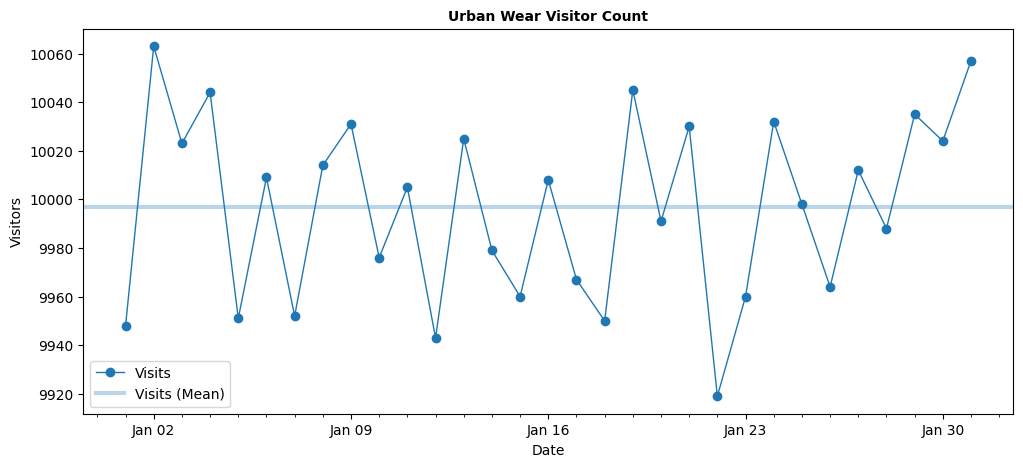

In [25]:
#Set the color pallete for the plot
colors = sns.color_palette()
c1, c2 = colors[0], colors[1]

#Count sign-ups by date
visits_per_day = pretest.groupby('date')['submitted'].count()
visits_mean = visits_per_day.mean()

#Plot Data
f, ax = plt.subplots(figsize=(12,5))
plt.plot(visits_per_day.index, visits_per_day, '-o', color = c1, linewidth = 1, label='Visits')
plt.axhline(visits_mean, color=c1, linestyle= '-', linewidth=3, alpha = 0.3, label = 'Visits (Mean)')


#Format plot
ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))
ax.xaxis.set_minor_locator(mdates.DayLocator())
plt.title('Urban Wear Visitor Count', fontsize=10, weight='bold')
plt.xlabel('Date', fontsize=10)
plt.ylabel('Visitors', fontsize=10)
plt.legend()
plt.show()

### **Plot Sign-Up Rate per Day**


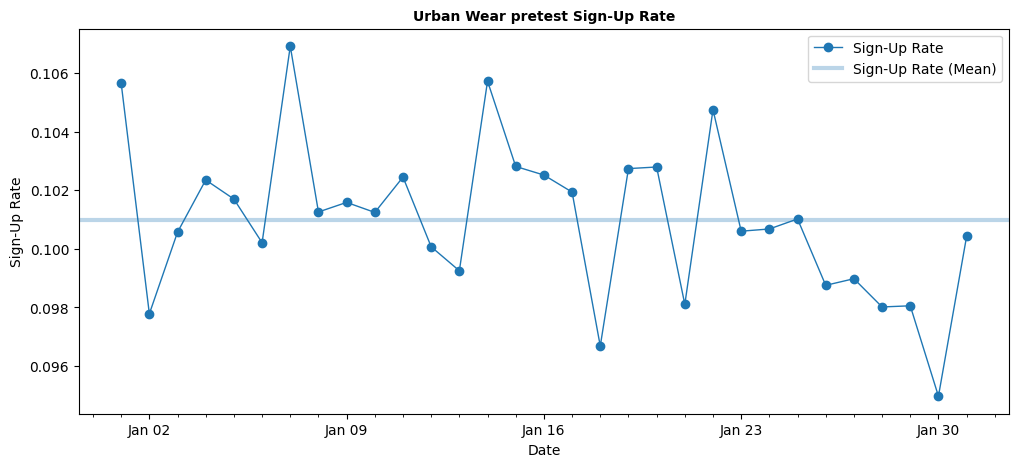

In [27]:
#Get the submission rate per day
signup_rate_per_day = pretest.groupby('date')['submitted'].mean()
signup_rate_mean = signup_rate_per_day.mean()

#Plot Data
f, ax = plt.subplots(figsize=(12,5))
plt.plot(signup_rate_per_day.index, signup_rate_per_day, '-o', color=c1, linewidth=1, label= 'Sign-Up Rate')
plt.axhline(signup_rate_mean, color = c1, linestyle = '-', linewidth = 3, alpha = 0.3, label = 'Sign-Up Rate (Mean)')

#Format Plot
ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax.xaxis.set_minor_locator(mdates.DayLocator())
plt.title('Urban Wear pretest Sign-Up Rate', fontsize = 10, weight = 'bold')
plt.xlabel('Date', fontsize=10)
plt.ylabel('Sign-Up Rate', fontsize=10)
plt.legend()
plt.show()

